# In this Notebook I am trying to get GCV to work 

In [31]:
from nanodrt.drt_solver.drt import DRT
from nanodrt.drt_solver.measurements import ImpedanceMeasurement
import jax.numpy as jnp 
import pandas as pd
from jax.numpy.linalg import cholesky

from nanodrt.fitting.optimizer import Optimizer
import matplotlib.pyplot as plt
from nanodrt.drt_solver.solvers import RBFSolver

from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)
import jaxopt

In [95]:
# Upload the Data and create a Measurement Object 

columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/ed_data_1.csv", header=None, names=columns)

f = jnp.array(df["f"].values)
tau = 1./(2*jnp.pi*f)
tau = jnp.flip(jnp.logspace(-4, 4, 500))

Z_exact_re =  jnp.array(df["Z_re"].values)
Z_exact_im =  jnp.array(df["Z_im"].values)

# Create our measurement object
measurement = ImpedanceMeasurement(Z_exact_re, Z_exact_im, f)

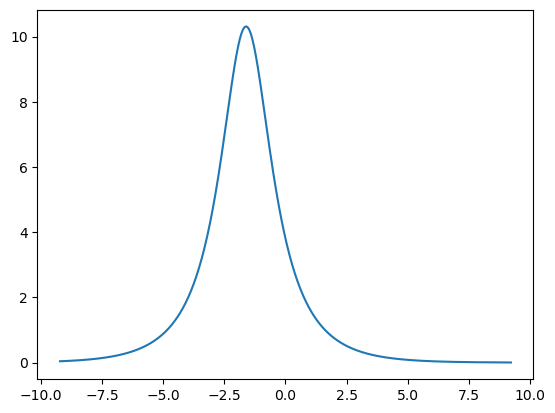

In [96]:
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7)
plt.plot(jnp.log(tau), gamma_guess)
plt.show()

In [97]:
drt = DRT(R_0= 10, L_0=0, gamma=gamma_guess, tau=tau)

Now we wish to make our simulation and extract the A_re and A_im matrices

In [98]:
integrals = RBFSolver(drt=drt, f_vec=measurement.f, log_t_vec=jnp.log(tau))
A_re, A_im = integrals()
print(jnp.shape(A_re))

(55, 500)


Now we create the column matrices

In [99]:
ones = jnp.ones(len(measurement.f))
zeros = jnp.zeros(len(measurement.f))
jnp.shape(zeros
          )

(55,)

In [100]:
jnp.shape(tau)

(500,)

Now we create the total A matrix

In [101]:
A_top = jnp.vstack((zeros, ones, A_re.T))
A_bottom = jnp.vstack((2.*jnp.pi*measurement.f, zeros, A_im.T))
A = jnp.hstack((A_top, A_bottom))
A.shape # size (N + 2, 2M)

(502, 110)

In [102]:
# Now we create the Z_exp 
Z_exp = jnp.hstack((measurement.Z_re, measurement.Z_im))
Z_exp.shape

(110,)

In [116]:

I = jnp.eye(jnp.array(jnp.shape(Z_exp))[0])
def GCV(lbd, Z_exp, A, I):
    lbd = jnp.abs(lbd)
    M2 = jnp.array(jnp.shape(Z_exp))
    K = (A.T@A)*jnp.linalg.inv(A.T@A - I*lbd)
    num = jnp.sum((I - K@Z_exp)**2)
    den = jnp.trace(I - K)**2/(M2)
    return (num/den)[0]

GCV(1e-10, Z_exp=Z_exp, A=A, I=I)

def compute_GCV(log_lambda, A_re, A_im, Z_re, Z_im, M):
    
    """
       This function computes the score for the generalized cross-validation (GCV) approach.
       Reference: G. Wahba, A comparison of GCV and GML for choosing the smoothing parameter in the generalized spline smoothing problem, Ann. Statist. 13 (1985) 1378–1402.
       Inputs: 
           log_lambda: regularization parameter
           A_re: discretization matrix for the real part of the impedance
           A_im: discretization matrix for the real part of the impedance
           Z_re: vector of the real parts of the impedance
           Z_im: vector of the imaginary parts of the impedance
           M: differentiation matrix 
       Output:
           GCV score
    """
    
    lambda_value = jnp.exp(log_lambda)
    Z = jnp.hstack(( Z_re, Z_im)) # stacked impedance

    n_cv = Z.shape[0] # n_cv = 2*N_freqs with N_freqs the number of EIS frequencies
    n_t = A_re.shape[1]

    n_cv2 = int(n_cv/2)
    ones = jnp.ones(n_cv2)
    zeros = jnp.zeros(n_cv2)

    A_top = jnp.vstack((zeros, ones, A_re.T))
    A_bottom = jnp.vstack((2.*jnp.pi*measurement.f, zeros, A_im.T))
    A = jnp.hstack((A_top, A_bottom))
    #print(A.shape) # size (N + 2, 2M)
        
    #A = jnp.concatenate((A_re, A_im), axis = 0) # matrix A with A_re and A_im ; see (5) in [4]
   
    n_cv = Z.shape[0] # n_cv = 2*N_freqs with N_freqs the number of EIS frequencies
    
    A_agm = A@A.T + lambda_value*M # see (13) in [4]
    
    #print(A_agm.shape)
    L_agm = jnp.linalg.cholesky(A_agm) # Cholesky transform to inverse A_agm
    inv_L_agm = jnp.linalg.inv(L_agm)
    inv_A_agm = inv_L_agm.T@inv_L_agm # inverse of A_agm
    A_GCV = A.T@inv_A_agm@A  # see (13) in [4]
    # GCV score; see (13) in [4]
    GCV_num = 1/n_cv*jnp.linalg.norm((jnp.eye(n_cv)-A_GCV)@Z)**2 # numerator
    GCV_dom = (1/n_cv*jnp.trace(jnp.eye(n_cv)-A_GCV))**2 # denominator
    
    GCV_score = GCV_num/GCV_dom
    
    return GCV_score


compute_GCV(-1, A_re, A_im, measurement.Z_re, measurement.Z_im,  jnp.eye(A_re.shape[1] + 2))

TypeError: add got incompatible shapes for broadcasting: (502, 502), (500, 500).

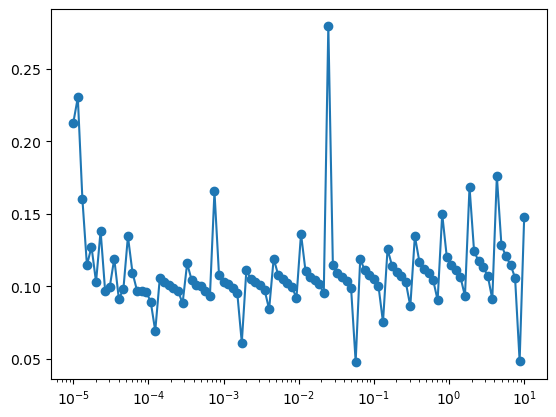

In [114]:
lbd = -5.
solver = jaxopt.LBFGS(fun=compute_GCV, maxiter=50000)
res = solver.run(jnp.array(lbd), A_re, A_im, measurement.Z_re, measurement.Z_im,  jnp.eye(A_re.shape[1]))
param, state = res
# Alternatively, we could have used one of these solvers as well:
# solver = jaxopt.GradientDescent(fun=ridge_reg_objective, maxiter=500)
# solver = jaxopt.ScipyMinimize(fun=ridge_reg_objective, method="L-BFGS-B", maxiter=500)
# solver = jaxopt.NonlinearCG(fun=ridge_reg_objective, method="polak-ribiere", maxiter=500)

lbd_values = jnp.logspace(-5, 1, 100)
GCV_values = [GCV(lbd, Z_exp, A, I) for lbd in lbd_values]
plt.plot(lbd_values, GCV_values, '-o')
plt.xscale("log")

In [115]:
params, state = res
print(jnp.exp(params), state)

0.00673794035325108 LbfgsState(iter_num=Array(1, dtype=int64, weak_type=True), value=Array(7.94010773e-06, dtype=float64), grad=Array(9.8632955e-07, dtype=float64), stepsize=Array(1., dtype=float64), error=Array(9.8632955e-07, dtype=float64), s_history=Array([-9.86329763e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00], dtype=float64), y_history=Array([-2.12474681e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00], dtype=float64), rho_history=Array([4.77167303e+18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00], dtype=float64), gamma=Array(4642104.93264309, dtype=float64), aux=None, failed_linesearch=Array(False, dtype=bool), num_fun_eva